### Pregunta 3 - ¿Existen grupos de juegos con patrones similares que permitan agruparlos para recomendaciones?

#### Análisis Preliminar de los Datos

Dada la naturaleza de la pregunta, corresponde establecer un límite inferior tanto para el número de reviews mínimo, como para un score aceptable para generar recomendaciones. Para encontrar estos valores primero evaluaremos el mínimo de reviews que tiene que tener un juego para ser considerado en el análisis.

In [131]:
import pandas as pd

csv_path = './df_reduced.csv'
df = pd.read_csv(csv_path, low_memory=False)


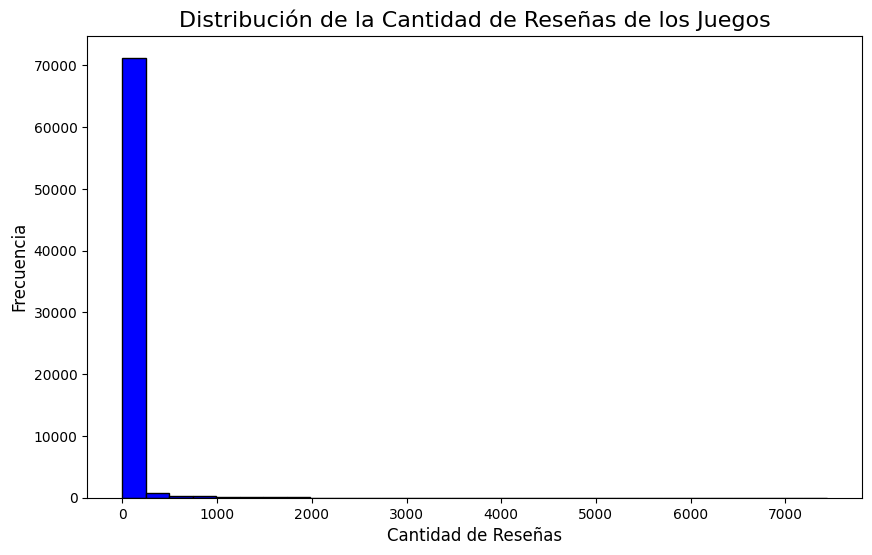

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# crear el gráfico
df_graph = df.dropna(subset=['review_review_count'])

plt.figure(figsize=(10, 6))
plt.hist(df_graph['review_review_count'], bins=30, color='blue', edgecolor='black')
plt.title('Distribución de la Cantidad de Reseñas de los Juegos', fontsize=16)
plt.xlabel('Cantidad de Reseñas', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

Aqui debemos filtrar aquellos juegos que no tengan reseñas, dado que no podemos recomendar juegos que nunca han sido reseñados. Para ello además de descartar aquellos juegos sin review podemos desarrollar un análisis de los percentiles

In [133]:
# calculamos percentiles
percentil_25 = df['review_review_count'].quantile(0.25)
percentil_50 = df['review_review_count'].quantile(0.50)
percentil_75 = df['review_review_count'].quantile(0.75)
percentil_90 = df['review_review_count'].quantile(0.90)

print(f"Percentil 25: {percentil_25}")
print(f"Percentil 50: {percentil_50}")
print(f"Percentil 75: {percentil_75}")
print(f"Percentil 90: {percentil_90}")

Percentil 25: 0.0
Percentil 50: 1.0
Percentil 75: 6.0
Percentil 90: 33.0


Ante esto consideramos el 25% de los datos, filtrando a partir del percentil 75 para nuestro análisis, así podemos considerar juegos con un número de recomendaciones aceptables

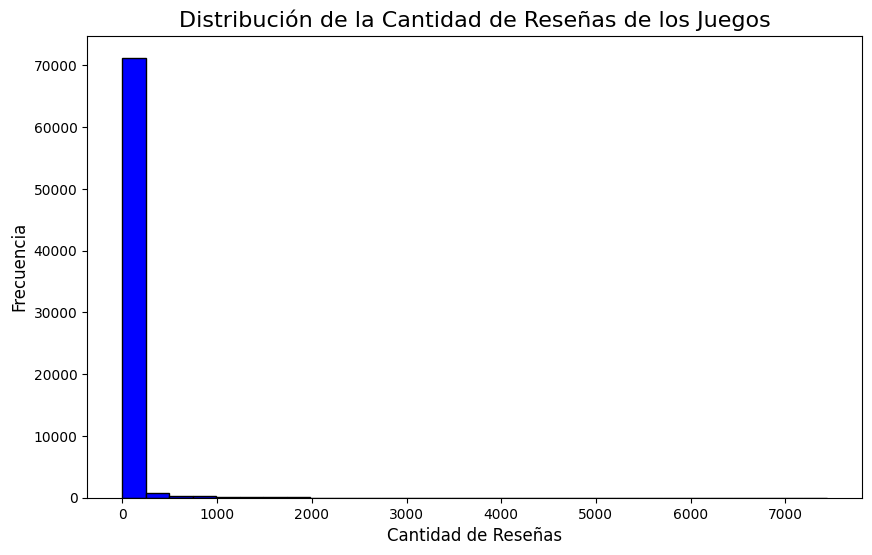

In [134]:
# Crear el gráfico

plt.figure(figsize=(10, 6))
plt.hist(df['review_review_count'], bins=30, color='blue', edgecolor='black')
plt.title('Distribución de la Cantidad de Reseñas de los Juegos', fontsize=16)
plt.xlabel('Cantidad de Reseñas', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

#### Construcción del Conjunto de Datos
Con respecto a la construcción del conjunto de los datos, para el caso particular de esta pregunta se realiza una separación binaria en el atributo 'game_profile_genre' que permitirá tomar de forma granular el genero de un juego y no como conjunto.

In [ ]:
# binarización de los generos

import sys
import os

sys.stderr = open(os.devnull, 'w')


df['game_profile_genre'] = df['game_profile_genre'].fillna('')
df['generos_lista'] = df['game_profile_genre'].str.split(',')

todos_los_generos = []
for lista in df['generos_lista']:
    for genero in lista:
        genero = genero.strip()
        if genero != '' and genero not in todos_los_generos:
            todos_los_generos.append(genero)

for genero in todos_los_generos:
    df[genero] = 0 

for i in range(len(df)):
    for genero in df.loc[i, 'generos_lista']:
        genero = genero.strip()
        if genero in todos_los_generos:
            df.loc[i, genero] = 1

df = df.drop(columns=['generos_lista'])

sys.stderr = sys.__stderr__


# reviews positivas
df = df[df['review_review_count'] > 0]
df = df[df['review_review_count'] > int(df['review_review_count'].quantile(0.75))]

#### Entrenamiento y evaluación del modelo

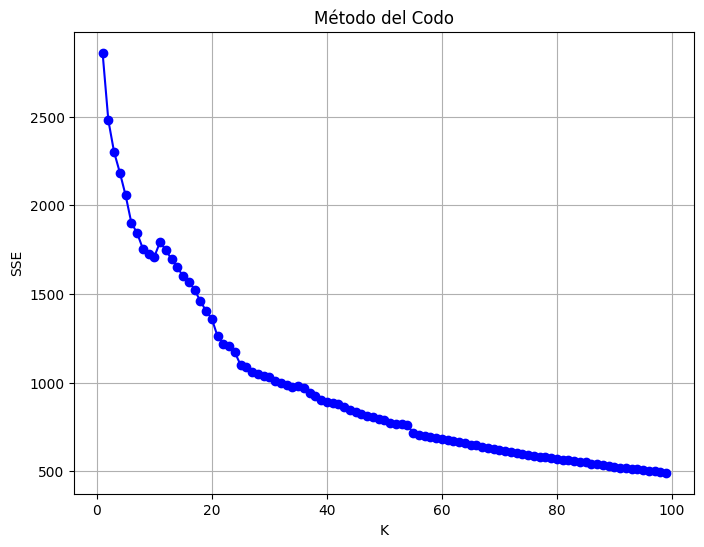

In [136]:
# busqueda del mejor k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# filtramos para tener juegos con reviews suficientes y con un score bueno
df_filtered = df[(df['review_review_count'] > 10) & (df['game_review_score'] > 80)]
genre_columns = df.columns[10:]
features = df_filtered[genre_columns]

k_range = range(1, 100)
sse = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o', color='b')
plt.title('Método del Codo')
plt.xlabel('K')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

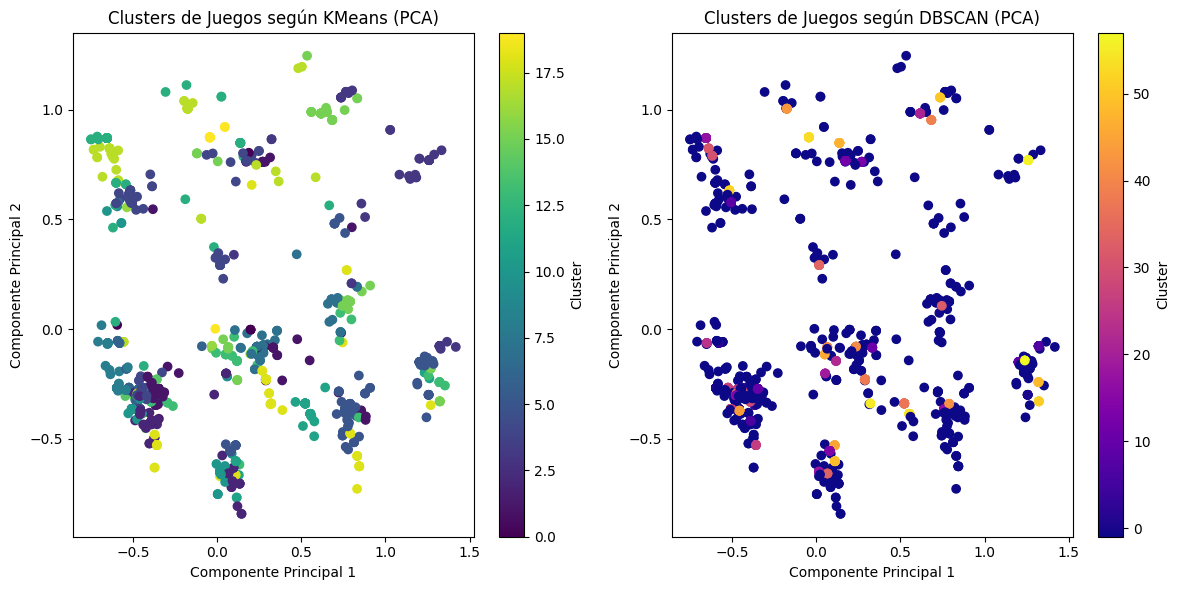

Juegos en el cluster 5, usando kmeans:
- A Hat in Time
- Assassin's Creed: Brotherhood
- Banjo-Kazooie
- Banjo-Tooie
- Batman: Arkham Asylum
- Batman: Arkham City
- Beyond Good & Evil
- Broken Sword II: The Smoking Mirror
- Bully
- Bully: Scholarship Edition
- Castlevania: Dawn of Sorrow
- Castlevania: Portrait of Ruin
- Devil May Cry 3: Dante's Awakening
- Dragon Quest Heroes: Rocket Slime
- Genma Onimusha
- God of War
- God of War Collection
- God of War II
- God of War III
- God of War Saga
- Ico
- Jet Set Radio Future
- Killer7
- Last Window: The Secret of Cape West
- Little Big Adventure 2
- Metal Gear Solid 2: Sons of Liberty
- Metal Gear Solid 3: Snake Eater
- Metal Gear Solid HD Collection
- Metroid Fusion
- Metroid Prime 2: Echoes
- Metroid Prime 3: Corruption
- Metroid Prime: Trilogy
- Metroid: Zero Mission
- Ninja Gaiden
- Ninja Gaiden Black
- ŌKAMI
- Outcast
- Policenauts
- Ratchet & Clank Collection
- Shenmue
- Shenmue II
- Star Control II: The Ur-Quan Masters
- Super Metr

In [137]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN

# aplicamos kmeans
kmeans = KMeans(n_clusters=20, random_state=0)
df_filtered['cluster_kmeans'] = kmeans.fit_predict(features)

# aplicamos dbscan
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_filtered['cluster_dbscan'] = dbscan.fit_predict(features)

# reducimos dimensiones para graficar y ver los clusters
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features)

df_filtered['PCA1'] = pca_components[:, 0]
df_filtered['PCA2'] = pca_components[:, 1]


plt.figure(figsize=(12, 6))

# grfico pca
plt.subplot(1, 2, 1)
plt.scatter(df_filtered['PCA1'], df_filtered['PCA2'], c=df_filtered['cluster_kmeans'], cmap='viridis')
plt.title('Clusters de Juegos según KMeans (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')

# grafico dbscan
plt.subplot(1, 2, 2)
plt.scatter(df_filtered['PCA1'], df_filtered['PCA2'], c=df_filtered['cluster_dbscan'], cmap='plasma')
plt.title('Clusters de Juegos según DBSCAN (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

# funcion que nos permite ver los nombres asociados a un cluster particular
def juegos_por_cluster(df, cluster_num, type='dbscan'):
    juegos_cluster = df[df[f'cluster_{type}'] == cluster_num]['game_game_name']
    
    if juegos_cluster.empty:
        print(f"No se encontraron juegos en el cluster {cluster_num}.")
    else:
        print(f"Juegos en el cluster {cluster_num}, usando {type}:")
        for juego in juegos_cluster:
            print(f"- {juego}")

juegos_por_cluster(df_filtered, 5, 'kmeans')         


#### Conclusiones Preliminares

El análisis exploratorio realizado, sustentado en la binarización de géneros y filtros de reseña y puntajes, permitió identificar agrupamientos coherentes entre titulos con perfiles de genero similares. Esta estrategia demostró ser efectiva para estructurar el conjunto de datos de manera significativa, enfocandose en juegos que, por su nivel de recepción y evaluación, representan un subconjunto más confiable del universo total.

La aplicación del Método del Codo, si bien no presentó un punto de inflexión claramente definido, nos otorgó una buena estimación para elegir 20 clusters como valor óptimo. Esta cantidad logró equilibrar tanto la representación de la diversidad de combinaciones de genero, como la cohesión interna dentro de cada grupo. Clusters como el seleccionado nos dan cuenta de la autenticidad de los resultados obtenidos, ya que al entregar RPG tácticos y narrativos clásicos como Final Fantasy, Disgaea o Dragon Quest, validan la utilidad del enfoque basado en géneros binarios como una herramienta potencial para sistemas de recomendación.

En cuanto a las técnicas de agrupamiento, los resultados muestran contrastes relevantes. K-Means produjo divisiones claras y bien delimitadas en el espacio proyectado por PCA, facilitando la interpretación y el análisis visual. En cambio, DBSCAN detectó sólo unos pocos clusters densos y clasificó el resto de los títulos como ruido. Este comportamiento, refleja la complejidad propia de los generos de videojuegos mixtos, ya que no es tan claro el limite entre estas categorías. Más allá de su menor eficacia para una agrupación general, su capacidad para destacar grupos densos con características muy similares puede ser útil en contextos específicos.

#### Posibles Mejoras

Una de las mejoras más relevantes consiste en ampliar el espacio de características más allá de la binarización de géneros, incorporar variables adicionales permitiría capturar aspectos que hoy quedan fuera del análisis. Por ejemplo, integrar métricas como el tiempo promedio de speedrun, su desviación estándar o incluso el tipo de final alcanzado, podría diferenciar entre juegos de ritmo vertiginoso y aquellos con un desarrollo más pausado, incluso dentro de un mismo género.

A la vez, añadir información contextual sobre las plataformas aportaría una capa adicional sobre la experiencia de juego. La inclusión de análisis de sentimiento o técnicas de extracción de temas a partir de reseñas y descripciones textuales podría reflejar la percepción real de la comunidad, identificando atributos más subjetivos que no son captados por los géneros formales. Esto ayudaría, por ejemplo, a distinguir entre un plataformero clásico con un juego del estilo metroidvania, que aunque comparten aspectos similares, sus experiencias de juego son en escencia muy diferentes.

En cuanto a los algoritmos, explorar con modelos jerárquicos podrían revelar relaciones más finas entre géneros y subgéneros, ya que con los modelos actuales no queda tan claro el punto de inflexión en juegos que tengan una combinación de generos altamente cohesionados, lo que si es mucho mas claro al considerarlos jerarquicamente.

Por ultimo, sería valioso aplicar metricas de validación como el coeficiente de silhouette, o incluso incluir encuestas a jugadores, para verificar que los clusters resultantes no solo sean coherentes desde un punto de vista estadístico, sino también relevantes y útiles desde la experiencia del usuario. Así, al tener datos más cercanos a la cotidianidad de los jugadores, se podría mejorar la calidad de los resultados obtenidos.